In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import r2_score
from matplotlib import pyplot as plt
import seaborn as sns

## Consider the 'HousePrice.csv' dataset which describes the features and sale price of a house.  Build  a  regression  model  using  regularization  to predict  the  value  of  the properties.

In [10]:
house_price = pd.read_csv('HousePrice.csv')
house_price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1. Perform the preprocessing if required, scale the train and test data using standard scaler.

In [11]:
corr = house_price.corr().abs()
sortedcorr = corr.unstack().sort_values(ascending=False)
corrdf = pd.DataFrame(sortedcorr)
print(corrdf[(corrdf[0] < 1) & (corrdf[0] > 0.75)])

                                  0
GarageArea   GarageCars    0.882475
GarageCars   GarageArea    0.882475
GarageYrBlt  YearBuilt     0.825667
YearBuilt    GarageYrBlt   0.825667
GrLivArea    TotRmsAbvGrd  0.825489
TotRmsAbvGrd GrLivArea     0.825489
TotalBsmtSF  1stFlrSF      0.819530
1stFlrSF     TotalBsmtSF   0.819530
OverallQual  SalePrice     0.790982
SalePrice    OverallQual   0.790982


In [12]:
# dropping one feature from each pair of correlated features
house_price.drop(['GarageArea', 'GarageYrBlt', 'GrLivArea', 'TotalBsmtSF'], axis=1, inplace=True)

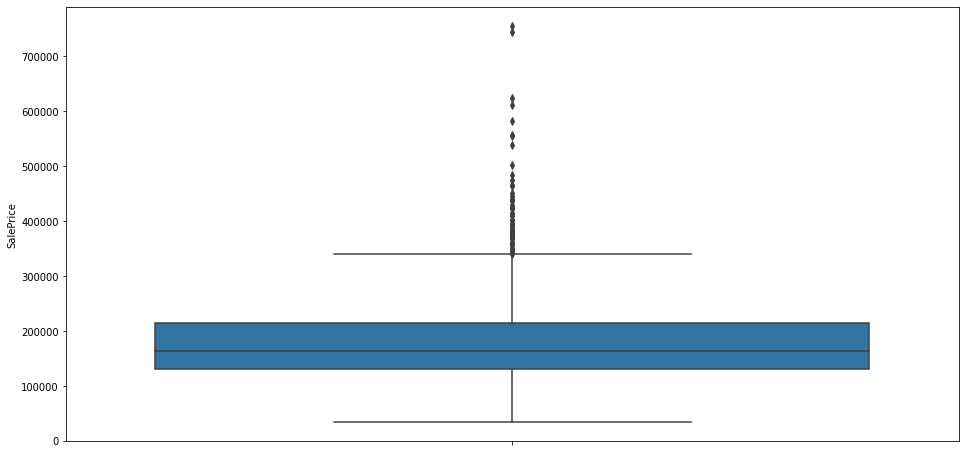

In [13]:
plt.figure(figsize=(16,8))
sns.boxplot(data= house_price, y='SalePrice')
plt.show()

#### The above plot shows presence of outliers

## 2. Split the dataset into train size of 70% and test size of 30% and Apply the Ridge and Lasso regression and fit the model containing all independent variables.

In [14]:
X = house_price.drop('SalePrice', axis=1)
Y = house_price['SalePrice']

# train-test-split (70, 30)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [15]:
# selecting numeric and categorical features for preprocessing
cat = X_train.select_dtypes(include='object')
num = X_train.select_dtypes(exclude='object')

In [16]:
num.drop('Id', axis=1, inplace=True)

/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [17]:
# median imputation for missing numerical values
imputer = SimpleImputer(missing_values=np.nan, strategy='median').fit(num)
num_imputed = imputer.transform(num)

In [18]:
# standard scaling
scaler = StandardScaler().fit(num_imputed)
numscaled = scaler.transform(num_imputed)

In [19]:
# final preprocessed numerical features
numeric_preprocessed = numscaled.copy()

In [20]:
# checking the percentage of missing values in categorical features
missing = pd.DataFrame(cat.isnull().sum()/len(cat), columns=['NaN'])
missing.sort_values(by=['NaN'], ascending=False)

,NaN
PoolQC,0.995108
MiscFeature,0.960861
Alley,0.935421
Fence,0.802348
FireplaceQu,0.476517
GarageType,0.052838
GarageCond,0.052838
GarageQual,0.052838
GarageFinish,0.052838
BsmtFinType1,0.025440


In [21]:
# dropping features with too many missing values
dropcat = missing[missing['NaN']>0.47]
cat.drop(dropcat.index, axis=1, inplace=True)

/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
# filling the rest of the missing values with 'None' (ex. instances with no pool)
cat.fillna('None', inplace=True)

/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [23]:
# adding a row with 'None' values for the encoder
none = pd.DataFrame(['None' for i in range(len(cat.columns))], cat.columns)
cat_all = house_price.select_dtypes(include='object')
cat_all.drop(dropcat.index, axis=1, inplace=True)
cat_all.fillna('None', inplace=True)
cat_all = cat_all.append(none.T, ignore_index=True)

In [24]:
# one hot encoding for categorical features
encoder = OneHotEncoder(sparse=False).fit(cat_all)
cat_enc = encoder.transform(cat)

In [25]:
# final preprocessed categorical features
categorical_preprocessed = cat_enc.copy()

In [26]:
# concatenating the preprocessed numeric and categorical features
X_train = np.concatenate([categorical_preprocessed, numeric_preprocessed], axis=1)

In [27]:
# combining all of the above into a function to preprocess the test data
def preprocess(data):
    
    num = data.select_dtypes(exclude='object')
    cat = data.select_dtypes(include='object')
    
    # NUMERIC
    
    # dropping 'Id'
    num.drop('Id', axis=1, inplace=True)
    
    # imputation
    num_imputed = imputer.transform(num)
    
    # standard scaling
    numscaled = scaler.transform(num_imputed)
    
    # final preprocessed array
    numeric_preprocessed = numscaled.copy()
    
    
    # CATEGORICAL
        
    # dropping features with too many missing values
    cat.drop(dropcat.index, axis=1, inplace=True)
    
    # filling the rest of the missing values with 'None'
    cat.fillna('None', inplace=True)
       
    # one hot encoding
    cat_enc = encoder.transform(cat)
    
    # final preprocessed array
    categorical_preprocessed = cat_enc.copy()
    
    # concatenating the preprocessed numeric and categorical features
    return np.concatenate([categorical_preprocessed, numeric_preprocessed], axis=1)

In [28]:
# preprocessing the test set
X_test = preprocess(X_test)

/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return sup

In [29]:
# standard scaling for the target feature
Y_scaler = StandardScaler().fit(Y_train.values.reshape(-1,1))
Y_train = Y_scaler.transform(Y_train.values.reshape(-1,1))
Y_test = Y_scaler.transform(Y_test.values.reshape(-1,1))

In [30]:
# checking best value of alpha for ridge regression

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

model = Ridge()

gridsearch = GridSearchCV(model, param_grid = params, cv = 5, scoring= 'neg_mean_squared_error')
gridsearch.fit(X_train, Y_train) 

gridsearch.best_params_

{'alpha': 100}

In [31]:
# fitting ridge regression model
ridge = Ridge(alpha=100)
ridge.fit(X_train, Y_train)

Ridge(alpha=100)

In [32]:
# making predictions
Y_pred = ridge.predict(X_test)

In [33]:
print("R2 Score = ",r2_score(Y_test, Y_pred))

R2 Score =  0.8632878434630751


In [34]:
# checking best value of alpha for lasso regression

model = Lasso()

gridsearch = GridSearchCV(model, param_grid = params, cv = 5, scoring= 'neg_mean_squared_error')
gridsearch.fit(X_train, Y_train) 

gridsearch.best_params_

{'alpha': 0.001}

In [35]:
lasso = Lasso(alpha=0.001)
lasso.fit(X_train, Y_train)
Y_pred = lasso.predict(X_test)

In [36]:
print("R2 Score = ", r2_score(Y_test, Y_pred))

R2 Score =  0.9020198211262037


#### The lasso reg model has higher r2 score than ridge reg model

## 3. Make predictions on test data “HousePriceTest.csv” and tabulate performance of both models on unseen data.

In [37]:
# reading unseen data
unseen = pd.read_csv("HousePriceTest.csv")
unseen.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [38]:
# preprocessing unseen data
unseen.drop(['GarageArea', 'GarageYrBlt', 'GrLivArea', 'TotalBsmtSF'], axis=1, inplace=True)
unseen_preprocessed = preprocess(unseen)

/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/manvendra07/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return sup

In [39]:
# making predictions
scaledpreds = lasso.predict(unseen_preprocessed)

In [40]:
# scaling predictions back to the original representation
actualpreds = Y_scaler.inverse_transform(scaledpreds, copy=None)

# tabulating predictions
actualpreds = pd.DataFrame(actualpreds, columns=['PredictedSalePrice'])
unseen = unseen.join(actualpreds)
unseen.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PredictedSalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,108064.200476
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,135618.191201
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,174972.006419
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,191553.727407
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,219179.045973
